In [0]:
#
# Google Drive에서 파일을 불러올 수 있도록 함
#

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
import skimage
from google.colab.patches import cv2_imshow

from skimage.io import imread
from skimage.transform import resize

#
# load_image_files는 정해진 path에서 폴더를 찾음.
# 이 경우, normal과 defect 2개의 폴더 내에 이미지 파일들이 들어가 있음.
# 이 Image file을 모두 들고와서 64 x 64 pixel로 줄임.
# 폴더(categori)와 이미지파일(data)을 반환
#

def load_image_files(container_path, dimension=(64, 64)):
    """
    Load image files with categories as subfolder names 
    which performs like scikit-learn sample dataset
    
    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one subfolder per category
    dimension : tuple
        size to which image are adjusted to
        
    Returns
    -------
    Bunch
    """
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            img = skimage.io.imread(file)
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            flat_data.append(img_resized.flatten()) 
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

In [0]:
image_dataset = load_image_files("/gdrive/My Drive/PythonVision/Cosmetic/")
print('data : ', image_dataset.data)
print('target : ', image_dataset.target)

data :  [[0.62829733 0.62745098 0.63614047 ... 0.54509804 0.53333333 0.53224188]
 [0.57254902 0.56470588 0.56862745 ... 0.56078431 0.5591299  0.5473652 ]
 [0.58823529 0.57647059 0.58823529 ... 0.53912377 0.54117647 0.5372549 ]
 ...
 [0.6        0.59607843 0.61176471 ... 0.6        0.58431373 0.60392157]
 [0.61960784 0.61568627 0.61078455 ... 0.63529412 0.62745098 0.64705882]
 [0.63137255 0.61960784 0.63137255 ... 0.65490196 0.64090074 0.66666667]]
target :  [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


In [0]:
#
# train_test_split을 이용, test data와 train data를 알아서 나눔.
# test_size, random_state를 바꾸어가며 확인하면 ok
#

X_train, X_test, y_train, y_test = train_test_split(
    image_dataset.data, image_dataset.target, test_size=0.3,random_state=10)

print('X_train : ' , X_train)
print('X_test : ', X_test)
print('y_train : ' , y_train)
print('y_test : ', y_test)

X_train :  [[0.60125613 0.59847987 0.6169424  ... 0.53333333 0.53333333 0.53333333]
 [0.55294118 0.54901961 0.55294118 ... 0.54757966 0.53973652 0.53333333]
 [0.65098039 0.65098039 0.65490196 ... 0.62329389 0.62329389 0.63011642]
 ...
 [0.57647059 0.57751225 0.56862745 ... 0.58039216 0.57957835 0.57254902]
 [0.60392157 0.59607843 0.61568627 ... 0.71764706 0.70196078 0.72941176]
 [0.6247549  0.6247549  0.63529412 ... 0.57254902 0.56470588 0.56862745]]
X_test :  [[0.61649984 0.61649984 0.61176471 ... 0.57096953 0.56761642 0.56312639]
 [0.52941176 0.52941176 0.51461397 ... 0.59518995 0.59607843 0.59518995]
 [0.61960784 0.62022442 0.61630285 ... 0.64926088 0.64313725 0.65882353]
 ...
 [0.55294118 0.55686275 0.55294118 ... 0.63921569 0.63921569 0.63921569]
 [0.69246324 0.69246324 0.6963848  ... 0.58823529 0.58431373 0.58431373]
 [0.6627451  0.6624112  0.65989583 ... 0.63137255 0.62245711 0.63137255]]
y_train :  [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
y_test :  [1 1 1 1

In [0]:
#
# param_grid에서 kernel의 형태를 정함.
# 두 가지의 형태 중에서 무엇이 더 뛰어난지는 알아서 결정함.
# 1번 형태와 2번 형태를 넣었을 때 2번이 더 좋다면, 결과는 2번만으로 반환.
#
# 아래에서 C는 초평면(kernel의 형태)에서 부터 얼마나 sample이 멀어져있는가를 의미.
# 이 값에 따라 정확도가 달라짐
#
# kernel의 경우, 여러 sample을 나눌 때에 선형으로 나눌 것인지, 비선형으로 나눌것인지,
# 비선형중에서는 어떤 형태로 나눌것인지 선택이 가능. 여기서는 rbf를 선택해보았음
#
# Cost가 되는 parameter는 kernel이 linear인 경우에는 C만 존재
# kernel이 rbf인 경우에는 C값과 gamma값이 됨.
#
param_grid = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}]

#
# SVC 객체 선언 
#
svc = svm.SVC()

#
# GridSearchCV 이용 -> 그리드를 사용한 복수 하이퍼 파라미터 최적화
# Wrapper 성격의 Class. -> 자동으로 복수개의 내부 모형을 생성, 이를 모두 실행시켜 최적 parameter를 찾아줌
# (물론 parameter들은 정해진 것들 중에서 결정하게 됨)
# 여기서 내부 test를 거쳐 가장 성능이 좋은 상태를 결정하게 됨.
#
# mean test score에서 성적이 가장 좋은 아이를 best parameter로 결정.
# 여기에서 C값이 1이고, kernel이 linear일 때 best performance가 나왔음.
#

clf = GridSearchCV(svc, param_grid)
gs = clf.fit(X_train, y_train)
print('Result for params : ' ,gs.cv_results_["params"])
print('Mean test score : ', gs.cv_results_["mean_test_score"])
print('best score : ', gs.best_score_)
print('best params : ', gs.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Result for params :  [{'C': 1, 'kernel': 'linear'}, {'C': 10, 'kernel': 'linear'}, {'C': 100, 'kernel': 'linear'}, {'C': 1000, 'kernel': 'linear'}, {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}, {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}, {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}]
Mean test score :  [0.96666667 0.96666667 0.96666667 0.96666667 0.86666667 0.86666667
 0.86666667 0.86666667 0.96666667 0.86666667 0.96666667 0.96666667]
best score :  0.9666666666666668
best params :  {'C': 1, 'kernel': 'linear'}


X_test :  [[0.61649984 0.61649984 0.61176471 ... 0.57096953 0.56761642 0.56312639]
 [0.52941176 0.52941176 0.51461397 ... 0.59518995 0.59607843 0.59518995]
 [0.61960784 0.62022442 0.61630285 ... 0.64926088 0.64313725 0.65882353]
 ...
 [0.55294118 0.55686275 0.55294118 ... 0.63921569 0.63921569 0.63921569]
 [0.69246324 0.69246324 0.6963848  ... 0.58823529 0.58431373 0.58431373]
 [0.6627451  0.6624112  0.65989583 ... 0.63137255 0.62245711 0.63137255]]
y_pred :  [1 1 1 1 1 1 0 1 1 1 1 1 1]


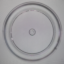

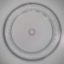

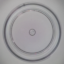

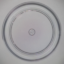

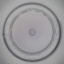

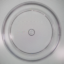

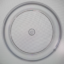

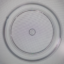

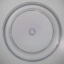

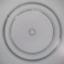

In [0]:
y_pred = clf.predict(X_test)
print('X_test : ', X_test)
print('y_pred : ', y_pred)
for i in range(0,10):
  cv2_imshow(image_dataset.images[i]*255)

In [0]:
print("Classification report for - \n{}:\n{}\n".format(
    clf, metrics.classification_report(y_test, y_pred, target_names=['normal', 'defect'])))

Classification report for - 
GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0):
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00         1
      defect       1.00      1.00      1.00        12

    accuracy  